# 房價預測模型
---
模型03 - L2 Regularization

使用Kaggle資料集預測房屋價格

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = pd.read_csv("kc_house_data.csv")
data.shape

pd.options.display.max_columns = 25
data.head()

# data.dtypes

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
data["year"] = pd.to_numeric(data["date"].str.slice(0, 4))
data["month"] = pd.to_numeric(data["date"].str.slice(4, 6))
data["day"] = pd.to_numeric(data["date"].str.slice(6, 8))

data.drop(["id"], axis=1, inplace=True)
data.drop(["date"], axis=1, inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [4]:
data_num = data.shape[0]
indexs = np.random.permutation(data_num)

train_indexs = indexs[:int(data_num*0.6)]
val_indexs = indexs[int(data_num*0.6):int(data_num*0.8)]
test_indexs = indexs[int(data_num*0.8):]

train_data = data.loc[train_indexs]
val_data = data.loc[val_indexs]
test_data = data.loc[test_indexs]

train_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
5407,158000.0,3,2.0,1090,6090,1.0,0,0,3,7,940,150,1940,0,98118,47.5118,-122.259,1840,6090,2015,5,6
17410,425000.0,3,2.5,1800,14036,2.0,0,0,3,8,1800,0,1993,0,98019,47.7334,-121.970,2450,14025,2015,3,25
21561,750000.0,5,4.0,4500,8130,2.0,0,0,3,10,4500,0,2007,0,98059,47.4832,-122.145,2840,8402,2015,1,15
19813,335606.0,3,2.5,2538,4600,2.0,0,0,3,8,2538,0,2013,0,98092,47.2584,-122.196,2570,4800,2014,7,8
8018,342000.0,4,1.0,1390,9023,1.5,0,0,3,7,1390,0,1955,0,98155,47.7754,-122.296,1760,9023,2015,4,22


In [5]:
mean = train_data.mean()
std = train_data.std()
train_data = (train_data - mean) / std

mean = val_data.mean()
std = val_data.std()
val_data = (val_data - mean) / std

# val_data.mean()
# val_data.std()

In [6]:
x_train = np.array(train_data.drop("price", axis=1))
y_train = np.array(train_data["price"])
x_val = np.array(val_data.drop("price", axis=1))
y_val = np.array(val_data["price"])

print(x_val.shape)
print(y_val.shape)

(4323, 21)
(4323,)


In [7]:
model = keras.Sequential(name="model-3")

model.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation="relu", input_shape=(21, )))
model.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation="relu"))
model.add(layers.Dense(1))

print(model.summary())

Model: "model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model.compile(keras.optimizers.Adam(0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [9]:
model_dir = "logs/models/"
if not os.path.exists(model_dir):
    print("new dir!")
    os.makedirs(model_dir)

log_dir = os.path.join("logs", "model-3")
model_cdk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir+"best-model-3.h5", monitor="val_mean_absolute_error", 
                                             save_best_only=True, mode="min")

In [10]:
history = model.fit(x_train, y_train, batch_size=64, epochs=100,
                    validation_data=(x_val, y_val), callbacks=[model_cdk, model_mckp])

Epoch 1/100
203/203 [==============================] - 3s 10ms/step - loss: 0.3913 - mean_absolute_error: 0.3383 - val_loss: 0.3070 - val_mean_absolute_error: 0.2939
Epoch 2/100
203/203 [==============================] - 1s 6ms/step - loss: 0.2799 - mean_absolute_error: 0.2767 - val_loss: 0.2680 - val_mean_absolute_error: 0.2676
Epoch 3/100
203/203 [==============================] - 1s 6ms/step - loss: 0.2469 - mean_absolute_error: 0.2536 - val_loss: 0.2373 - val_mean_absolute_error: 0.2495
Epoch 4/100
203/203 [==============================] - 1s 6ms/step - loss: 0.2300 - mean_absolute_error: 0.2438 - val_loss: 0.2347 - val_mean_absolute_error: 0.2505
Epoch 5/100
203/203 [==============================] - 1s 6ms/step - loss: 0.2090 - mean_absolute_error: 0.2315 - val_loss: 0.2029 - val_mean_absolute_error: 0.2266
Epoch 6/100
203/203 [==============================] - 1s 6ms/step - loss: 0.1985 - mean_absolute_error: 0.2257 - val_loss: 0.1955 - val_mean_absolute_error: 0.2213
Epoch 7/1

203/203 [==============================] - 1s 6ms/step - loss: 0.1031 - mean_absolute_error: 0.1776 - val_loss: 0.1278 - val_mean_absolute_error: 0.1965
Epoch 51/100
203/203 [==============================] - 1s 6ms/step - loss: 0.0987 - mean_absolute_error: 0.1742 - val_loss: 0.1240 - val_mean_absolute_error: 0.1871
Epoch 52/100
203/203 [==============================] - 2s 7ms/step - loss: 0.1025 - mean_absolute_error: 0.1761 - val_loss: 0.1319 - val_mean_absolute_error: 0.1986
Epoch 53/100
203/203 [==============================] - 1s 6ms/step - loss: 0.0980 - mean_absolute_error: 0.1744 - val_loss: 0.1236 - val_mean_absolute_error: 0.1854
Epoch 54/100
203/203 [==============================] - 1s 7ms/step - loss: 0.1000 - mean_absolute_error: 0.1765 - val_loss: 0.1251 - val_mean_absolute_error: 0.1883
Epoch 55/100
203/203 [==============================] - 1s 6ms/step - loss: 0.0976 - mean_absolute_error: 0.1732 - val_loss: 0.1343 - val_mean_absolute_error: 0.1917
Epoch 56/100
203/

203/203 [==============================] - 2s 8ms/step - loss: 0.0893 - mean_absolute_error: 0.1698 - val_loss: 0.1646 - val_mean_absolute_error: 0.2053
Epoch 100/100
203/203 [==============================] - 1s 6ms/step - loss: 0.0907 - mean_absolute_error: 0.1700 - val_loss: 0.1305 - val_mean_absolute_error: 0.1943


Text(0.5, 1.0, 'MSE')

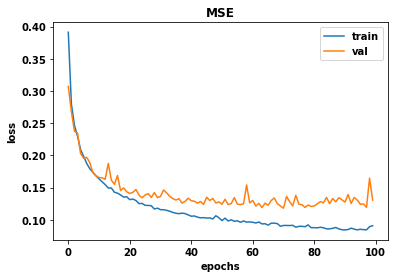

In [11]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.title('MSE')

Text(0.5, 1.0, 'MAE')

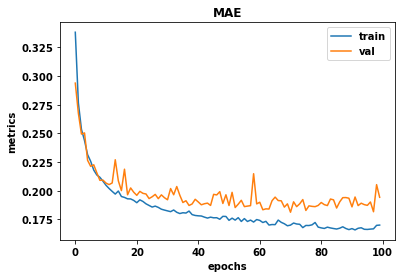

In [12]:
plt.plot(history.history["mean_absolute_error"], label="train")
plt.plot(history.history["val_mean_absolute_error"], label="val")
plt.xlabel("epochs")
plt.ylabel("metrics")
plt.legend(loc="upper right")
plt.title('MAE')

In [13]:
model.load_weights("logs/models/best-model-3.h5")

y_test = np.array(test_data["price"])
mean = test_data.mean()
std = test_data.std()
test_data = (test_data - mean) / std
x_test = np.array(test_data.drop("price", axis=1))

y_pred = model.predict(x_test)

y_pred = np.reshape(y_pred * std["price"] + mean["price"], y_test.shape)
precentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100

print("Model precentage error: {:.2f}%".format(precentage_error))

Model precentage error: 12.96%


In [14]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [15]:
# %reload_ext tensorboard